In [1]:
import tensorflow as tf
import os
import numpy as np
import uuid
import mediapipe as mp
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D,MaxPool2D,Input,Flatten,Dense,Layer
import cv2
from sklearn.utils import shuffle
import Taking_input

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

Getting data

In [2]:
def getting_data():
#Collecting data to train

    k = os.listdir("D:\smart_attendance\data")

    x_1 = []
    x_2 = []
    y_data = []
    #positive input and validation person
    for roll_no in k:
        path = os.path.join(r"D:\smart_attendance\data",roll_no)
        images = os.listdir(path)
        if(len(images)>10):
            random_images = np.random.choice(images,18,replace = False)
        else:
            random_images = np.random.choice(images,len(images),replace = False)
        for i in range(len(random_images)):
            temp1 = cv2.imread(os.path.join(path,random_images[i]))
            temp1 = cv2.cvtColor(temp1,cv2.COLOR_BGR2GRAY)
            for j in range(i,len(random_images)):
                temp2 = cv2.imread(os.path.join(path,random_images[j]))
                temp2 = cv2.cvtColor(temp2,cv2.COLOR_BGR2GRAY)
                x_1.append(temp1/255.0)
                x_2.append(temp2/255.0)
                y_data.append(1.0)



    #negative input and validation person
    for i in range(len(k)):
        img1_path = os.path.join(r"D:\smart_attendance\data",k[i])
        imgs1_lis = np.random.choice(os.listdir(img1_path),12,replace=False)
        imgs1 = []
        imgs2 = []
        for f in imgs1_lis:
            t1 = cv2.imread(os.path.join(img1_path,f))
            imgs1.append(cv2.cvtColor(t1,cv2.COLOR_BGR2GRAY))
        for j in range(len(k)):
            if(i == j ):
                continue
            img2_path = os.path.join(r"D:\smart_attendance\data",k[j])
            imgs2_lis = np.random.choice(os.listdir(img2_path),3,replace=False)
            for s in imgs2_lis:
                t2 = cv2.imread(os.path.join(img2_path,s))
                imgs2.append(cv2.cvtColor(t2,cv2.COLOR_BGR2GRAY))
        for temp1 in imgs1:
            for temp2 in imgs2:
                x_1.append(temp1/255.0)
                x_2.append(temp2/255.0)
                y_data.append(0.0)

    return x_1,x_2,y_data


Siamese Model

In [3]:
def make_embedding():
    inp = Input(shape=(105,105,1), name = "input_image")
    # layer 1
    c1 = Conv2D(64,(10,10),activation="relu")(inp)
    m1 = MaxPool2D(64,(2,2),padding="same")(c1)

    # Layer 2
    c2 = Conv2D(128,(7,7),activation="relu")(m1)
    m2 = MaxPool2D(64,(2,2),padding="same")(c2)

    # Layer 3
    c3 = Conv2D(128,(4,4),activation="relu")(m2)
    m3 = MaxPool2D(64,(2,2),padding="same")(c3)

    # Layer 4
    c4 = Conv2D(256,(4,4),activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation="sigmoid")(f1)

    return Model(inputs = [inp], outputs = [d1],name = "embedding")

embed = make_embedding()

class L1Distace(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


def make_siamese():

    input_image = Input((105,105,1),name="Input_Image")
    validation_image = Input((105,105,1),name = "Validation_image")

    siamense = L1Distace()
    input_embedding = embed(input_image)
    validation_embedding = embed(validation_image)
    dist = siamense(input_embedding,validation_embedding)

    #Last Layer

    classify = Dense(1,activation="sigmoid")(dist)

    return Model(inputs = [input_image,validation_image],outputs = [classify], name = "siamense_model")

Data for train and test

In [ ]:
siamese = make_siamese()
siamese.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
filepath = "/content/drive/MyDrive/smart_attendance"
if(not os.path.exists(filepath)):
    os.makedirs(filepath)
call_backs = tf.keras.callbacks.ModelCheckpoint(filepath,save_weights_only=True,verbose = 1)
x_in,x_val,y = getting_data()
x_in,x_val,y = shuffle(np.array(x_in),np.array(x_val),np.array(y))
history = siamese.fit([np.array(x_in),np.array(x_val)], np.array(y),epochs=50, validation_split = 0.2,callbacks = [call_backs] , batch_size = 64)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.5302
Epoch 1: saving model to /content/drive/MyDrive/smart_attendance
20/20 [==============================] - 23s 1s/step - loss: 0.6376 - accuracy: 0.5302 - val_loss: 0.6729 - val_accuracy: 0.5175
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.5587
Epoch 2: saving model to /content/drive/MyDrive/smart_attendance
20/20 [==============================] - 13s 664ms/step - loss: 0.6158 - accuracy: 0.5587 - val_loss: 0.6191 - val_accuracy: 0.5683
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.5770
Epoch 3: saving model to /content/drive/MyDrive/smart_attendance
20/20 [==============================] - 13s 665ms/step - loss: 0.5997 - accuracy: 0.5770 - val_loss: 0.6268 - val_accuracy: 0.5746
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.6111
Epoch 4: saving model to /content/dr

In [ ]:
siamese.predict(list(np.expand_dims([x_in[3],x_val[3]],axis=1)))

1/1 [==============================] - 0s 21ms/step


array([[0.6689689]], dtype=float32)

In [ ]:
siamese.save("/content/drive/MyDrive/smart_attendance/siamese1.h5")

In [21]:
model = tf.keras.models.load_model("D:\smart_attendance\siamese1.h5",custom_objects={"L1Distace":L1Distace,"BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [1]:
x_in,x_val,y = getting_data()
x_in,x_val,y = shuffle(np.array(x_in),np.array(x_val),np.array(y))
model.predict(list(np.expand_dims([x_in[56],x_val[56]],axis=1)))

NameError: name 'getting_data' is not defined

Data Visualization

1/1 [==============================] - 0s 234ms/step
[[0.15156707]]
False


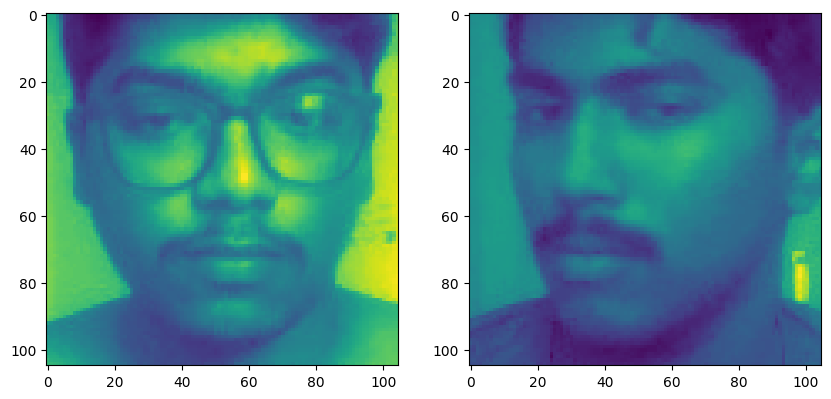

In [23]:
n = 56
y = model.predict(list(np.expand_dims([x_in[n],x_val[n]],axis=1)))
print(y)
if(y>0.5):
  print("True")
else:
  print("False")
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(x_in[n])
plt.subplot(1,2,2)
plt.imshow(x_val[n])

Real time testing

In [7]:
roll_numbers_path = os.path.join("D:\smart_attendance\data")
roll_numbers = os.listdir(roll_numbers_path)
labels_images = dict()
for roll_number in roll_numbers:
  imgs_path = os.path.join(roll_numbers_path,roll_number)
  imgs = os.listdir(imgs_path)
  chose_imgs = np.random.choice(imgs,10,replace = False)
  k_imgs = []
  for k in chose_imgs:
    img = cv2.imread(os.path.join(imgs_path,k))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    k_imgs.append(img/255.0)
  labels_images[roll_number] = np.array(k_imgs)

face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence = 0.5)

cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret,frame = cap.read()
  if not ret:
    continue
  
  frame = cv2.flip(frame,1)

  rgb_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  results = face_detection.process(rgb_frame)

  if results.detections:
    for detection in results.detections:
      height,width,depth = frame.shape
      bboxC = detection.location_data.relative_bounding_box
      x, y, w, h = int(bboxC.xmin * width), int(bboxC.ymin * height), int(bboxC.width * width), int(bboxC.height * height)
      cv2.rectangle(frame,(x-20,y-20),(x+w+15,y+h+15),(0,255,255))
      if cv2.waitKey(10) == ord('a'):
        image = frame[y-10:y+h+10,x-10:x+w+10]
        image = cv2.resize(image,(105,105))
        x_in = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        x_in = np.array(x_in/255.0)
        res = ""
        y_hat = 0
        for i in labels_images:
          f=[]
          for x_val in labels_images[i]:
            y = model.predict(list(np.expand_dims([np.array(x_in),np.array(x_val)],axis=1)))
            f.append(y)
          print(max(f))
          if y_hat < max(f):
            y_hat = max(f)
            res = i
        if(y_hat>0.4):
          print(res)
        else:
          print("None of the face matches")
  cv2.imshow(" ",frame)
  if cv2.waitKey(10) == ord('q'):
      break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 219ms/step
[[5.134651e-07]]
1/1 [==============================] - 0s 243ms/step
[[0.00272563]]
1/1 [==============================] - 0s 218ms/step
[[0.00277871]]
1/1 [==============================] - 0s 237ms/step
[[3.6396254e-05]]
1/1 [==============================] - 0s 231ms/step
[[0.49572906]]
1/1 [==============================] - 0s 224ms/step
[[0.00119085]]
Ec21b1039
